# Stephen Allwright's additions to the Hepatitus project
To further show the extent of my skills within data science I have undertaken some extra work on the original project sent to me.

The basis of the project remains the same with the following additions:
- KFold validator added (Section 5.1)
- GridSearchCV for parameter tweaking (Section 6)
- Feature importance in the RandomForest model (Section 7)
- Experimentation with PCA (Section 8)

## 1.0 Importing and adjusting the data

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#define a custom palette
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)
plt.style.use('fivethirtyeight')

In [136]:
col_names = ['Class', 'Age', 'Sex', 'Steroid', 'Antivirals', 'Fatigue', 'Malaise', 'Anorexia', 'Liver_big', 'Liver_firm', 'Spleen_palpable', 'Spiders', 'Ascites', 'Varices', 'Bilirubin', 'Alk_phosphate', 'Sgot', 'Albumin', 'Protime', 'Histology']
df = pd.read_csv('hepatitis.data', sep=',', header=None, )
df.columns = col_names
df.replace('?', np.nan, inplace=True)

numeric_features = ['Age', 'Bilirubin', 'Alk_phosphate', 'Sgot', 'Albumin', 'Protime']
categorical_features = ['Sex', 'Steroid', 'Antivirals', 'Fatigue', 'Malaise', 'Anorexia', 'Liver_big', 'Liver_firm', 'Spleen_palpable', 'Spiders', 'Ascites', 'Varices', 'Histology']

In [137]:
df = df.sample(frac=1)

X = df.as_matrix(df.columns[1:])
y = df.as_matrix(['Class']).ravel()

### 1.1 Missing data

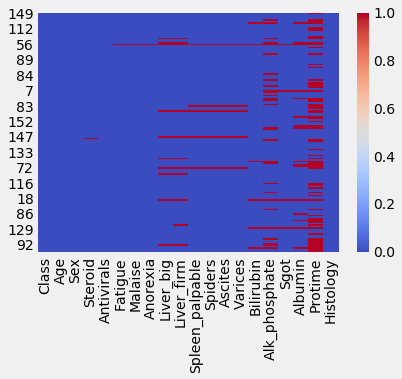

In [138]:
sns.heatmap(data=df.isna(),cmap='coolwarm')

In [139]:
# Imputing Protime with Median

df['Protime'].fillna((df['Protime'].median()), inplace=True)

# Drop the rest of the missing data

df.dropna(axis=0, how='any', inplace=True)

## 2.0 Exploration of the data

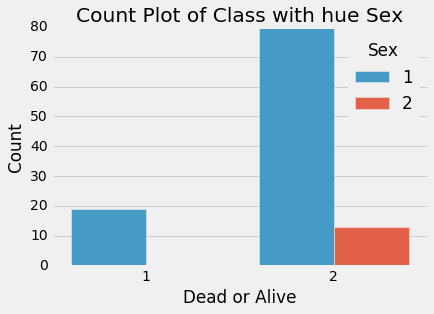

In [140]:
ax = sns.countplot(x=df['Class'],data=df,hue='Sex')
plt.title('Count Plot of Class with hue Sex')
plt.ylabel('Count')
plt.xlabel('Dead or Alive');

## 3.0 Feature preprocessing and engineering

In [141]:
df_categorical = df[categorical_features]
df_numeric = df[numeric_features]

X_categorical = df_categorical.as_matrix()
X_numeric = df_numeric.as_matrix()
y = np.ravel(df['Class'])

In [142]:
# Scaling the numerical features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_preprocessed = scaler.fit_transform(X_numeric)

/Users/stephenallwright/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [143]:
# Bringing it all together

X = np.concatenate((X_categorical,X_numeric),axis=1)

## 4.0 Implementing initial models

In [144]:
from sklearn import metrics

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [145]:
names = ["Nearest Neighbors", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "MLP", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [146]:
# Setting up a report dataframe
results_data = {'Name': names}
results = pd.DataFrame(data=results_data)
results.index = names
results.drop('Name', axis=1, inplace=True)

## 5.0 Training the models (Naive validation scheme)

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for i, name in enumerate(names):
    clf = classifiers[i]
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    results.loc[name, 'Acc_naive'] = accuracy.mean()
    
results = results.round(3)
results.sort_values('Acc_naive', ascending=False)

/Users/stephenallwright/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Acc_naive
RBF SVM,0.811
Random Forest,0.811
MLP,0.811
QDA,0.811
Logistic Regression,0.811
Nearest Neighbors,0.784
Naive Bayes,0.757
AdaBoost,0.730
Gaussian Process,0.703
Decision Tree,0.676


### 5.1 Training with Cross Validation Scheme

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score

In [149]:
validator = KFold(n_splits=5,shuffle=False)
# Could also use the StratifiedKFold:
# validator = StratifiedKFold(n_splits=5)

In [150]:
for i, name in enumerate(names):
    clf = classifiers[i]
    scores = cross_val_score(clf, X, y, cv=validator)
    
    results.loc[name, 'Acc CV'] = scores.mean()
    results.loc[name, 'Std*2'] = scores.std()*2 # estimated 95% confidence interval

/Users/stephenallwright/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/stephenallwright/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/stephenallwright/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/stephenallwright/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/stephenallwright/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:6

In [151]:
results = results.round(2)
results.sort_values('Acc CV', ascending=False)

,Acc_naive,Acc CV,Std*2
AdaBoost,0.73,0.85,0.12
Random Forest,0.81,0.84,0.19
RBF SVM,0.81,0.83,0.13
MLP,0.81,0.83,0.16
QDA,0.81,0.83,0.13
Logistic Regression,0.81,0.83,0.10
Nearest Neighbors,0.78,0.77,0.06
Decision Tree,0.68,0.76,0.14
Gaussian Process,0.70,0.73,0.20
Naive Bayes,0.76,0.72,0.15


## 6.0 Parameter tuning
When undertaking a machine learning project it's important to always evaluate your models to see if there is room for improvement in accuracy. In this example I have used GridSearchCV to find the optimal parameteres for 3 of my most accurate models: AdaBoost, RandomForest, and SVM.

In [152]:
from sklearn.model_selection import GridSearchCV

In [175]:
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
ada_param_grid = {'learning_rate': [10,1,1e-1,1e-2,1e-3,1e-4]}

rf_param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

svm_param_grid = {'kernel': ['rbf','linear'], 
                  'gamma': [1e-3, 1e-4],
                  'C': [1, 10, 100, 1000]}

grid_search_ada = GridSearchCV(AdaBoostClassifier(), param_grid=ada_param_grid)
grid_search_ada.fit(X,y)

grid_search_rf = GridSearchCV(RandomForestClassifier(),param_grid=rf_param_grid)
grid_search_rf.fit(X,y)

grid_search_svm = GridSearchCV(SVC(),param_grid=svm_param_grid)
grid_search_svm.fit(X,y)

print('The best parameters for the AdaBoost model were:')
report(grid_search_ada.cv_results_)

print('The best parameters for the RandomForest model were:')
report(grid_search_rf.cv_results_)

print('The best parameters for the SVC model were:')
report(grid_search_svm.cv_results_)

The best parameters for the AdaBoost model were:
Model with rank: 1
Mean validation score: 0.821 (std: 0.012)
Parameters: {'learning_rate': 0.1}

Model with rank: 1
Mean validation score: 0.821 (std: 0.033)
Parameters: {'learning_rate': 0.01}

The best parameters for the RandomForest model were:
Model with rank: 1
Mean validation score: 0.893 (std: 0.023)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}

The best parameters for the SVC model were:
Model with rank: 1
Mean validation score: 0.848 (std: 0.053)
Parameters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}



### 6.1 Results
From the above results it's clear that there is some room for improvement with our models by tuning the parameters. For example with RandomForest we could improve accuracy from 84% to 89% by choosing the right parameters.

## 7.0 Feature importance in the dataset
I have chosen to undertake some further analysis into the feature importance of our data set. Asking the question "which features have the largest impact on the outcome?".

To do this I used the RandomForest model as my base model for the analysis.

In [168]:
# Calculating feature importance in the Random Forest model

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(categorical_features+numeric_features, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Bilirubin            Importance: 0.2
Variable: Alk_phosphate        Importance: 0.188
Variable: Protime              Importance: 0.148
Variable: Albumin              Importance: 0.125
Variable: Sgot                 Importance: 0.084
Variable: Age                  Importance: 0.064
Variable: Spiders              Importance: 0.037
Variable: Ascites              Importance: 0.036
Variable: Varices              Importance: 0.03
Variable: Anorexia             Importance: 0.017
Variable: Liver_firm           Importance: 0.017
Variable: Histology            Importance: 0.017
Variable: Fatigue              Importance: 0.015
Variable: Antivirals           Importance: 0.008
Variable: Liver_big            Importance: 0.007
Variable: Malaise              Importance: 0.003
Variable: Spleen_palpable      Importance: 0.003
Variable: Sex                  Importance: 0.0
Variable: Steroid              Importance: 0.0


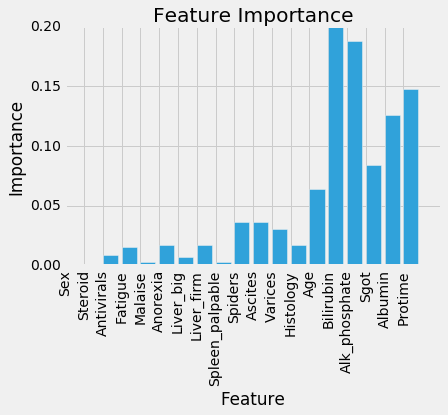

In [171]:
x_values = list(range(len(importances)))
plt.bar(x_values,importances,orientation='vertical')
plt.xticks(x_values,categorical_features+numeric_features,rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance');

### 7.1 Results
As we can see from the plot above there are a few feautures which contribute significantly to the outcome of the model. This could be used to better understand diagnosis and which factors to keep an eye out for.

## 8.0 Using PCA
If this dataset were to have more features then we may want to use PCA to reduce the training time whilst maintaining a high level of accuracy. To illustrate how this would be done I have create the simple model below.

In [163]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95) # we want to keep 95% of the variance
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))

print('Our model was reduced from {} features to {} features using PCA'.format(len(df.columns)-1,len(pca_data.columns)))

Our model was reduced from 19 features to 3 features using PCA


In [160]:
pca_data.head()

,0,1,2
0,-37.932846,33.656712,0.204633
1,91.660584,151.075059,9.402004
2,-60.726152,-10.846444,2.903184
3,-80.526355,-29.669269,-5.250921
4,-9.320865,-23.599120,2.024470
